In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

import joblib
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [68]:

df_host = pd.read_csv('host_data.csv')
df_loc = pd.read_csv('location_data.csv')
df_pric = pd.read_csv('pricing_data.csv')
df_prop = pd.read_csv('property_data.csv')
df_rev = pd.read_csv('review_data.csv')

In [69]:
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]
for i in dfs:
    print(i.isna().sum())

customer_id                   0
host_since                  173
host_response_rate        17193
host_has_profile_pic        173
host_identity_verified      173
dtype: int64
customer_id         0
neighbourhood    9550
latitude            0
longitude           0
city                0
zipcode           894
dtype: int64
customer_id            0
log_price              0
cleaning_fee           0
cancellation_policy    0
dtype: int64
customer_id        0
property_type      0
room_type          0
bedrooms          83
bathrooms        182
accommodates       0
beds             113
dtype: int64
customer_id                 0
number_of_reviews           0
review_scores_rating    15733
first_review            14932
last_review             14896
dtype: int64


In [70]:
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]
for i in dfs:
    print(i.shape)
    print(i.head(1))

(69546, 5)
                                         customer_id  host_since  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  10/07/2013   

  host_response_rate host_has_profile_pic host_identity_verified  
0               100%                    t                      t  
(69546, 6)
                                         customer_id     neighbourhood  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  Columbia Heights   

    latitude  longitude city zipcode  
0  38.921768 -77.030985   DC   20009  
(69546, 4)
                                         customer_id  log_price  cleaning_fee  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        4.0         False   

  cancellation_policy  
0            moderate  
(69546, 7)
                                         customer_id property_type  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        house    

        room_type  bedrooms  bathrooms  accommodates  beds  
0   private room        1.0        1.0       

In [71]:
for i, df in enumerate(dfs, start=1):
    num_duplicates = df.duplicated(subset=['customer_id'], keep=False).sum()
    print(f"DataFrame {i}: {num_duplicates} duplicate rows based on 'customer_id'")

DataFrame 1: 2728 duplicate rows based on 'customer_id'
DataFrame 2: 2728 duplicate rows based on 'customer_id'
DataFrame 3: 2728 duplicate rows based on 'customer_id'
DataFrame 4: 2728 duplicate rows based on 'customer_id'
DataFrame 5: 2728 duplicate rows based on 'customer_id'


In [72]:
for i, df in enumerate(dfs, start=1):
    num_duplicates = df.duplicated(keep=False).sum()
    print(f"DataFrame {i}: {num_duplicates} fully identical rows")

DataFrame 1: 2728 fully identical rows
DataFrame 2: 2728 fully identical rows
DataFrame 3: 2728 fully identical rows
DataFrame 4: 2728 fully identical rows
DataFrame 5: 2728 fully identical rows


In [73]:
df_host = df_host.drop_duplicates(keep='first')
df_loc = df_loc.drop_duplicates(keep='first')
df_pric = df_pric.drop_duplicates(keep='first')
df_prop = df_prop.drop_duplicates(keep='first')
df_rev = df_rev.drop_duplicates(keep='first')
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]

In [74]:
for i in dfs:
    print(i.shape)
    print(i.head(1))

(68182, 5)
                                         customer_id  host_since  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  10/07/2013   

  host_response_rate host_has_profile_pic host_identity_verified  
0               100%                    t                      t  
(68182, 6)
                                         customer_id     neighbourhood  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  Columbia Heights   

    latitude  longitude city zipcode  
0  38.921768 -77.030985   DC   20009  
(68182, 4)
                                         customer_id  log_price  cleaning_fee  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        4.0         False   

  cancellation_policy  
0            moderate  
(68182, 7)
                                         customer_id property_type  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        house    

        room_type  bedrooms  bathrooms  accommodates  beds  
0   private room        1.0        1.0       

In [75]:
df = df_host.merge(df_loc, on='customer_id', how='inner') \
                   .merge(df_pric, on='customer_id', how='inner') \
                   .merge(df_rev, on='customer_id', how='inner') \
                   .merge(df_prop, on='customer_id', how='inner')
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [76]:
df['review_scores_rating'] = df['review_scores_rating'].fillna(50)

In [77]:
df['host_identity_verified'] = df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0])
df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0])

df['host_response_rate'] = df['host_response_rate'].astype(str).str.rstrip('%')
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')
median_value = df['host_response_rate'].median()
df['host_response_rate'].fillna(median_value, inplace=True)

df['host_since'] = (pd.to_datetime(datetime.now()) - df['host_since']).dt.days / 365
df['host_since'] = df['host_since'].fillna(df['host_since'].median())

/tmp/ipykernel_5741/2536609328.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_response_rate'].fillna(median_value, inplace=True)


In [78]:
df['host_response_rate'].isna().sum()

np.int64(0)

In [79]:
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])

df['bedrooms'] = df['bedrooms'].replace(-1, 1)


In [80]:
df.isna().sum()

customer_id                   0
host_since                    0
host_response_rate            0
host_has_profile_pic          0
host_identity_verified        0
neighbourhood              9368
latitude                      0
longitude                     0
city                          0
zipcode                     876
log_price                     0
cleaning_fee                  0
cancellation_policy           0
number_of_reviews             0
review_scores_rating          0
first_review              14619
last_review               14583
property_type                 0
room_type                     0
bedrooms                      0
bathrooms                     0
accommodates                  0
beds                          0
dtype: int64

In [81]:
#Change t/f to True and False
df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'t': True, 'f': False}).astype(bool)
df['host_identity_verified'] = df['host_identity_verified'].map({'t': True, 'f': False}).astype(bool)
#Capatalize values in room_type and property_type to have a uniform standard between values
df['room_type'] = df['room_type'].str.upper()
df['property_type'] = df['property_type'].str.upper()

In [82]:
from fill_loc_data import FillLocData
if (df['zipcode'].isna().sum() > 0) and (os.path.exists('df_filled.csv') ):
    df = pd.read_csv('df_filled.csv' , index_col = None)

if (df['zipcode'].isna().sum() > 0) : 
    df = FillLocData().fill_zipcode(df)
    df.to_csv('df_filled.csv' , index=False)

if (df['neighbourhood'].isna().sum() > 0) : 
    df = FillLocData().fill_neighbourhood(df)
    df.to_csv('df_filled.csv' , index=False)


In [83]:
df.isna().sum()

customer_id                   0
host_since                    0
host_response_rate            0
host_has_profile_pic          0
host_identity_verified        0
neighbourhood                 0
latitude                      0
longitude                     0
city                          0
zipcode                       0
log_price                     0
cleaning_fee                  0
cancellation_policy           0
number_of_reviews             0
review_scores_rating          0
first_review              14619
last_review               14583
property_type                 0
room_type                     0
bedrooms                      0
bathrooms                     0
accommodates                  0
beds                          0
dtype: int64

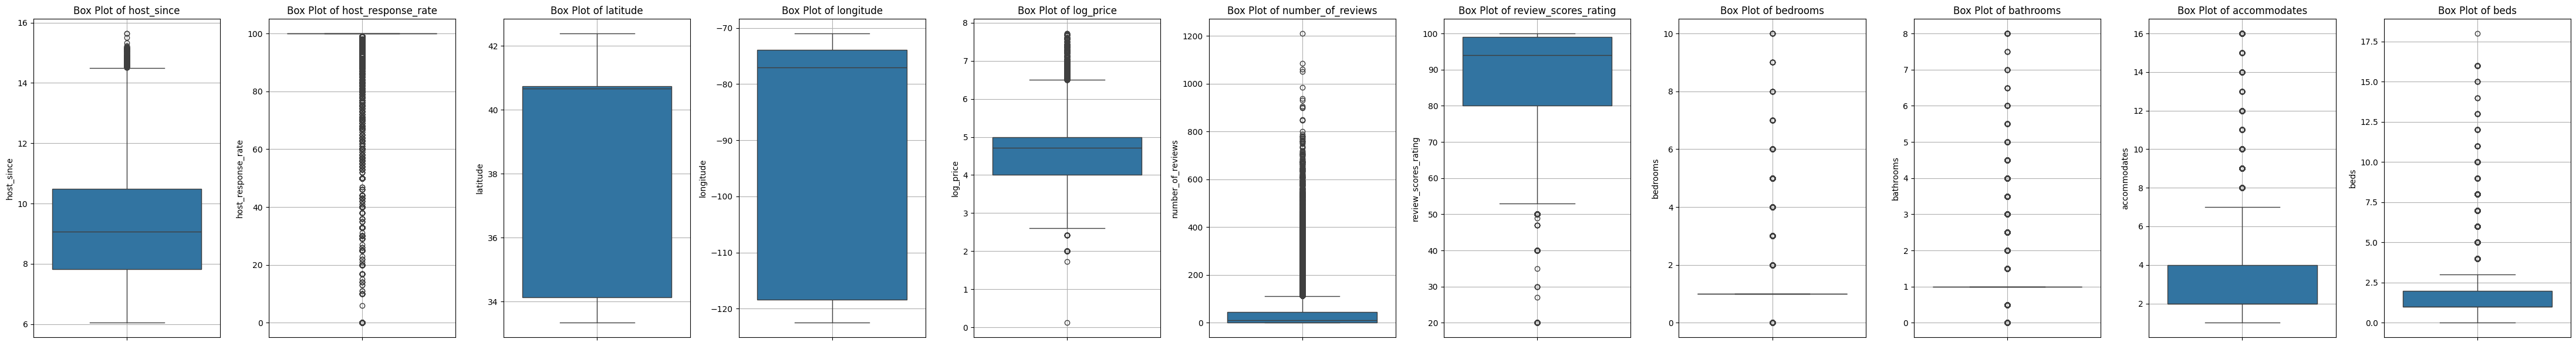

In [84]:
numerical_cols = df.select_dtypes(include=['number']).columns

num_cols = len(numerical_cols)
fig, axes = plt.subplots(1, num_cols, figsize=(4 * num_cols, 6))
for ax, col in zip(axes, numerical_cols):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')
    ax.set_ylabel(col)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [85]:
cols_to_drop = ['customer_id' , 'latitude','longitude','zipcode' , 'first_review' , 'last_review' , 'neighbourhood' , 'city']
df_dropped = df.drop(columns=cols_to_drop, axis = 1)



In [86]:
categorical_columns = ['cancellation_policy', 'property_type', 'room_type']
df_with_dummies = pd.get_dummies(df_dropped, columns=categorical_columns, drop_first=True)


In [87]:
model_scores = {}
X = df_with_dummies.drop(columns=['log_price'])
y = df_with_dummies['log_price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
saved_model_name = 'model_lr_TUNED.joblib'

param_grid = {
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_lr_TUNED = loaded_model
else:
    grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5 , n_jobs = -1)
    grid_search.fit(X_train, y_train)
    model_lr_TUNED = grid_search.best_estimator_
    joblib.dump(model_lr_TUNED, saved_model_name)

y_pred = model_lr_TUNED.predict(X_test)

train_score = model_lr_TUNED.score(X_train, y_train)
test_score = model_lr_TUNED.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

params = model_lr_TUNED.get_params()

model_scores['Linear Regression TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used Parameters': params
}

print(f"Train Score (R²): {train_score}")
print(f"Test Score (R²): {test_score}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Train Score (R²): 0.43913856911379445
Test Score (R²): 0.4388511065482328
Mean Squared Error: 0.34618196405050755
R² Score: 0.4388511065482328


In [89]:
saved_model_name_ridge = 'model_ridge_TUNED.joblib'
saved_model_name_lasso = 'model_lasso_TUNED.joblib'

param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}

param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}

# Ridge Regression
if os.path.exists(saved_model_name_ridge):
    model_ridge_TUNED = joblib.load(saved_model_name_ridge)
else:
    grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5 , n_jobs = -1)
    grid_search_ridge.fit(X_train, y_train)
    model_ridge_TUNED = grid_search_ridge.best_estimator_
    joblib.dump(model_ridge_TUNED, saved_model_name_ridge)

y_pred_ridge = model_ridge_TUNED.predict(X_test)

train_score_ridge = model_ridge_TUNED.score(X_train, y_train)
test_score_ridge = model_ridge_TUNED.score(X_test, y_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

params_ridge = model_ridge_TUNED.get_params()

model_scores['Ridge Regression TUNED'] = {
    'Train Score': train_score_ridge,
    'Test Score': test_score_ridge,
    'Mean Squared Error': mse_ridge,
    'R2 Score': r2_ridge,
    'Used Parameters': params_ridge
}

print(f"Ridge Regression - Train Score (R²): {train_score_ridge}")
print(f"Ridge Regression - Test Score (R²): {test_score_ridge}")
print(f"Ridge Regression - Mean Squared Error: {mse_ridge}")
print(f"Ridge Regression - R² Score: {r2_ridge}")



Ridge Regression - Train Score (R²): 0.4391240282989176
Ridge Regression - Test Score (R²): 0.4389775442538778
Ridge Regression - Mean Squared Error: 0.3461039625543253
Ridge Regression - R² Score: 0.4389775442538778


In [90]:
if os.path.exists(saved_model_name_lasso):
    model_lasso_TUNED = joblib.load(saved_model_name_lasso)
else:
    grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5 , n_jobs = -1)
    grid_search_lasso.fit(X_train, y_train)
    model_lasso_TUNED = grid_search_lasso.best_estimator_
    joblib.dump(model_lasso_TUNED, saved_model_name_lasso)

y_pred_lasso = model_lasso_TUNED.predict(X_test)

train_score_lasso = model_lasso_TUNED.score(X_train, y_train)
test_score_lasso = model_lasso_TUNED.score(X_test, y_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

params_lasso = model_lasso_TUNED.get_params()

model_scores['Lasso Regression TUNED'] = {
    'Train Score': train_score_lasso,
    'Test Score': test_score_lasso,
    'Used Parameters': params_lasso
}

print(f"Lasso Regression - Train Score (R²): {train_score_lasso}")
print(f"Lasso Regression - Test Score (R²): {test_score_lasso}")
print(f"Lasso Regression - Mean Squared Error: {mse_lasso}")
print(f"Lasso Regression - R² Score: {r2_lasso}")

Lasso Regression - Train Score (R²): 0.42135730268220006
Lasso Regression - Test Score (R²): 0.41656520835928557
Lasso Regression - Mean Squared Error: 0.35993050048300873
Lasso Regression - R² Score: 0.41656520835928557


In [91]:
saved_model_name_elastic = 'model_elastic_TUNED.joblib'

param_grid_elastic = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9],
    'fit_intercept': [True, False]
}

# Elastic Net Regression
if os.path.exists(saved_model_name_elastic):
    model_elastic_TUNED = joblib.load(saved_model_name_elastic)
else:
    grid_search_elastic = GridSearchCV(ElasticNet(), param_grid_elastic, cv=5 , n_jobs = -1)
    grid_search_elastic.fit(X_train, y_train)
    model_elastic_TUNED = grid_search_elastic.best_estimator_
    joblib.dump(model_elastic_TUNED, saved_model_name_elastic)

y_pred_elastic = model_elastic_TUNED.predict(X_test)

train_score_elastic = model_elastic_TUNED.score(X_train, y_train)
test_score_elastic = model_elastic_TUNED.score(X_test, y_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

params_elastic = model_elastic_TUNED.get_params()
alpha_used = params_elastic['alpha']
l1_ratio_used = params_elastic['l1_ratio']

model_scores['Elastic Net Regression TUNED'] = {
    'Train Score': train_score_elastic,
    'Test Score': test_score_elastic,
    'Used Parameters': params_elastic
}

print(f"Elastic Net Regression - Train Score (R²): {train_score_elastic}")
print(f"Elastic Net Regression - Test Score (R²): {test_score_elastic}")
print(f"Elastic Net Regression - Mean Squared Error: {mse_elastic}")
print(f"Elastic Net Regression - R² Score: {r2_elastic}")
print(f"Elastic Net Regression - Lambda (Alpha): {alpha_used}")
print(f"Elastic Net Regression - L1 Ratio: {l1_ratio_used}")


Elastic Net Regression - Train Score (R²): 0.42956840441587696
Elastic Net Regression - Test Score (R²): 0.4269059495451202
Elastic Net Regression - Mean Squared Error: 0.35355112749444223
Elastic Net Regression - R² Score: 0.4269059495451202
Elastic Net Regression - Lambda (Alpha): 0.01
Elastic Net Regression - L1 Ratio: 0.1


In [92]:
saved_model_name_dt = 'model_dt_TUNED.joblib'

param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['mse', 'friedman_mse', 'mae']
}

if os.path.exists(saved_model_name_dt):
    model_dt_TUNED = joblib.load(saved_model_name_dt)
else:
    grid_search_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5 , n_jobs = -1)
    grid_search_dt.fit(X_train, y_train)
    model_dt_TUNED = grid_search_dt.best_estimator_
    joblib.dump(model_dt_TUNED, saved_model_name_dt)

y_pred_dt = model_dt_TUNED.predict(X_test)

train_score_dt = model_dt_TUNED.score(X_train, y_train)
test_score_dt = model_dt_TUNED.score(X_test, y_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

params_dt = model_dt_TUNED.get_params()

model_scores['Decision Tree Regression TUNED'] = {
    'Train Score': train_score_dt,
    'Test Score': test_score_dt,
    'Used Parameters': params_dt
}

print(f"Decision Tree Regression - Train Score (R²): {train_score_dt}")
print(f"Decision Tree Regression - Test Score (R²): {test_score_dt}")
print(f"Decision Tree Regression - Mean Squared Error: {mse_dt}")
print(f"Decision Tree Regression - R² Score: {r2_dt}")
print(f"Decision Tree Regression - Best Parameters: {params_dt}")

/home/d/Documents/GitHub/GROUP5/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
360 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/d/Documents/GitHub/GROUP5/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/d/Documents/GitHub/GROUP5/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/d/Documents/Git

Decision Tree Regression - Train Score (R²): 0.4436428396850187
Decision Tree Regression - Test Score (R²): 0.4381257016477824
Decision Tree Regression - Mean Squared Error: 0.346629478241661
Decision Tree Regression - R² Score: 0.4381257016477824
Decision Tree Regression - Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


In [93]:
saved_model_name_rf = 'model_rf_TUNED.joblib'

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

if os.path.exists(saved_model_name_rf):
    model_rf_TUNED = joblib.load(saved_model_name_rf)
else:
    grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5 , n_jobs = -1)
    grid_search_rf.fit(X_train, y_train)
    model_rf_TUNED = grid_search_rf.best_estimator_
    joblib.dump(model_rf_TUNED, saved_model_name_rf)

y_pred_rf = model_rf_TUNED.predict(X_test)

train_score_rf = model_rf_TUNED.score(X_train, y_train)
test_score_rf = model_rf_TUNED.score(X_test, y_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

params_rf = model_rf_TUNED.get_params()

model_scores['Random Forest Regression TUNED'] = {
    'Train Score': train_score_rf,
    'Test Score': test_score_rf,
    'Used Parameters': params_rf
}

print(f"Random Forest Regression - Train Score (R²): {train_score_rf}")
print(f"Random Forest Regression - Test Score (R²): {test_score_rf}")
print(f"Random Forest Regression - Mean Squared Error: {mse_rf}")
print(f"Random Forest Regression - R² Score: {r2_rf}")
print(f"Random Forest Regression - Best Parameters: {params_rf}")

/home/d/Documents/GitHub/GROUP5/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest Regression - Train Score (R²): 0.5205608327784675
Random Forest Regression - Test Score (R²): 0.4644150558945941
Random Forest Regression - Mean Squared Error: 0.3304111440473282
Random Forest Regression - R² Score: 0.4644150558945941
Random Forest Regression - Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
saved_model_name_gb = 'model_gb_TUNED.joblib'

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

if os.path.exists(saved_model_name_gb):
    model_gb_TUNED = joblib.load(saved_model_name_gb)
else:
    grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5 , n_jobs = -1)
    grid_search_gb.fit(X_train, y_train)
    model_gb_TUNED = grid_search_gb.best_estimator_
    joblib.dump(model_gb_TUNED, saved_model_name_gb)

y_pred_gb = model_gb_TUNED.predict(X_test)

train_score_gb = model_gb_TUNED.score(X_train, y_train)
test_score_gb = model_gb_TUNED.score(X_test, y_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

params_gb = model_gb_TUNED.get_params()

model_scores['Gradient Boosting Regression TUNED'] = {
    'Train Score': train_score_gb,
    'Test Score': test_score_gb,
    'Used Parameters': params_gb
}

print(f"Gradient Boosting Regression - Train Score (R²): {train_score_gb}")
print(f"Gradient Boosting Regression - Test Score (R²): {test_score_gb}")
print(f"Gradient Boosting Regression - Mean Squared Error: {mse_gb}")
print(f"Gradient Boosting Regression - R² Score: {r2_gb}")
print(f"Gradient Boosting Regression - Best Parameters: {params_gb}")

In [29]:
saved_model_name_xgb = 'model_xgb_TUNED.joblib'

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

if os.path.exists(saved_model_name_xgb):
    model_xgb_TUNED = joblib.load(saved_model_name_xgb)
else:
    grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=5, n_jobs=-1, scoring='r2')
    grid_search_xgb.fit(X_train, y_train)
    model_xgb_TUNED = grid_search_xgb.best_estimator_
    joblib.dump(model_xgb_TUNED, saved_model_name_xgb)

y_pred_xgb = model_xgb_TUNED.predict(X_test)

train_score_xgb = model_xgb_TUNED.score(X_train, y_train)
test_score_xgb = model_xgb_TUNED.score(X_test, y_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

params_xgb = model_xgb_TUNED.get_params()

model_scores['XGBoost Regression TUNED'] = {
    'Train Score': train_score_xgb,
    'Test Score': test_score_xgb,
    'Used Parameters': params_xgb
}

# Print the results
print(f"XGBoost Regression - Train Score (R²): {train_score_xgb}")
print(f"XGBoost Regression - Test Score (R²): {test_score_xgb}")
print(f"XGBoost Regression - Mean Squared Error: {mse_xgb}")
print(f"XGBoost Regression - R² Score: {r2_xgb}")
print(f"XGBoost Regression - Best Parameters: {params_xgb}")

XGBoost Regression - Train Score (R²): 0.5263514472375739
XGBoost Regression - Test Score (R²): 0.4744917491322297
XGBoost Regression - Mean Squared Error: 0.32419466657255086
XGBoost Regression - R² Score: 0.4744917491322297
XGBoost Regression - Best Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_l

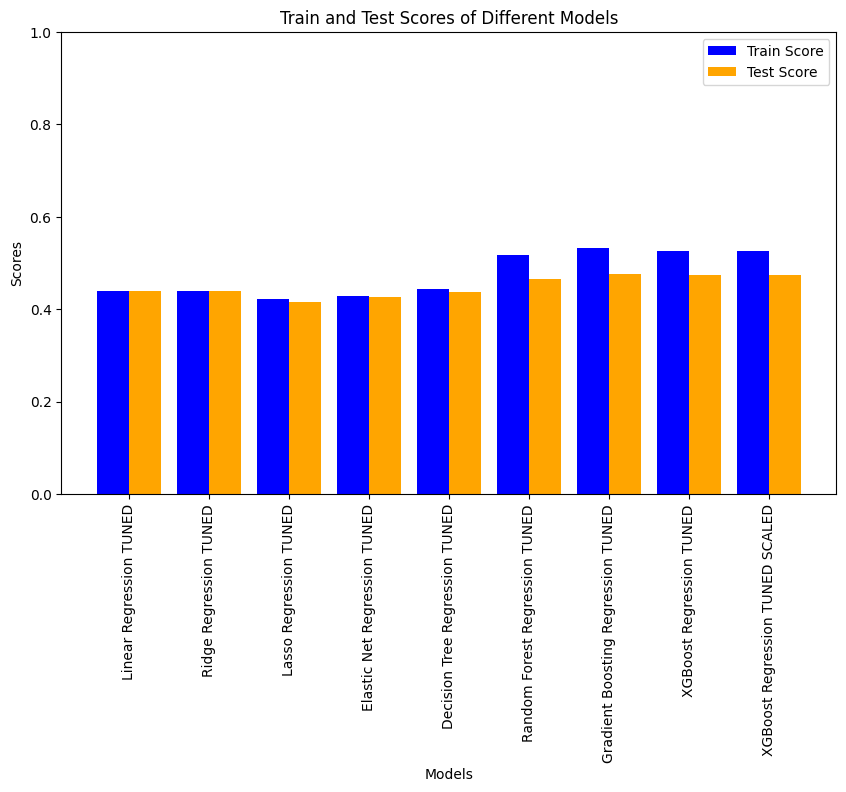

In [ ]:
models = list(model_scores.keys())
train_scores = [model_scores[model]["Train Score"] for model in models]
test_scores = [model_scores[model]["Test Score"] for model in models]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=0.4, label='Train Score', color='b', align='center')
plt.bar([p + 0.4 for p in x], test_scores, width=0.4, label='Test Score', color='orange', align='center')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Train and Test Scores of Different Models')
plt.xticks([p + 0.2 for p in x], models , rotation =90)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
best_model = max(model_scores, key=lambda x: model_scores[x]['Test Score'])
print('the best model -', best_model)
print(model_scores[best_model]['Train Score']) 
print(model_scores[best_model]['Test Score'])

worst_model = min(model_scores, key=lambda x: model_scores[x]['Test Score'])
print('the worst model -', worst_model)
print(model_scores[worst_model]['Train Score']) 
print(model_scores[worst_model]['Test Score'])


the best model - Gradient Boosting Regression TUNED
0.5315968269322284
0.476180965294871
the worst model - Lasso Regression TUNED
0.4213573026822003
0.41656520835928557
